# Research Project Topic
I will be using simulation data to determine the kinematics of disk stars in the MW and M31 merger remnant, focusing on rotation, velocities, and dispersions.  

### Question(s) to be pursued
The questions I will be addressing are:
What does the velocity dispersion as a function of radius look like?
Is the stellar remnant rotating, and is it a fast or slow rotator?

### Plot(s) to be produced
Phase diagrams (x vs vy) etc. velocity dispersion vs radius

In [1]:
#first, import necessary modules
import numpy as np
import astropy.units as u
from astropy.constants import G

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm

%matplotlib inline
from Readfile import Read
from CenterOfMass import CenterOfMass
#import MassProfile

In [2]:
#since the MW and M31 merge at ~ 6.3 Gyr, pick a snapshot to look at that is a bit of time after that
#I decided to use the last snapshot (Snapshot 800, time = 12 Gyr)

#step one: Calculate the COM of the merger remnant
#step two: calculate the positions/velocities of all the disk particles relative to that COM
#step three: calculate the mean velocity as a function of radius

In [3]:
#execute step 1
#create a COM object for MW and M31
# Create a Center of mass object for the MW, M31
MWCOM = CenterOfMass("MW_800.txt", 2)
M31COM = CenterOfMass("M31_800.txt", 2)

# MW:   store the position and velocity COM
MW_COMP = MWCOM.COM_P(0.1, 2.0)
print("MW COM Position = ", MW_COMP)
MW_COMV = MWCOM.COM_V(MW_COMP[0], MW_COMP[1], MW_COMP[2])
print("MW COM Velocity = ", MW_COMV)

#M31: store position and velocity COM
M31_COMP = M31COM.COM_P(0.1, 2.0)
print("M31 COM Position = ", M31_COMP)
M31_COMV = M31COM.COM_V(M31_COMP[0], M31_COMP[1], M31_COMP[2])
print("M31 COM Velocity = ", M31_COMV)

#should I use the snapshot where the COMs are the closest and just use one of them? Or should I take an average and use
#that average as the merger COM?

MW COM Position =  [190.74  23.63 146.6 ] kpc
MW COM Velocity =  [ 31.49 -18.96  26.68] km / s
M31 COM Position =  [190.85  23.61 145.87] kpc
M31 COM Velocity =  [ 31.77 -22.64  27.23] km / s


In [4]:
#for now I will just set the COM position and velocity to be equal to that calculated for the MW
MergerCOMP = MW_COMP.value
MergerCOMV = MW_COMV.value

#execute step 2
#convert all positions and velocities to be with respect to COM of system
def COMDataConverter(filename, particletype):
    #read in file and extract needed data from it
    time, total, data = Read(filename)
    
    #store data for wanted particle type 
    index = np.where(data['type'] == particletype)
    xnew = data['x'][index]
    ynew = data['y'][index]
    znew = data['z'][index]
    vxnew = data['vx'][index]
    vynew = data['vy'][index]
    vznew = data['vz'][index]
    massnew = data['m'][index]
    
    # Store positions and velocities of particles of given ptype from the COMP. 
    xnew2 = np.array(xnew - MergerCOMP[0])
    ynew2 = np.array(ynew - MergerCOMP[1])
    znew2 = np.array(znew - MergerCOMP[2])
    vxnew2 = np.array(vxnew - MergerCOMV[0])
    vynew2 = np.array(vynew - MergerCOMV[1])
    vznew2 = np.array(vznew - MergerCOMV[2])
    
    #return desired quantities
    return xnew2, ynew2, znew2, vxnew2, vynew2, vznew2

In [5]:
#store new position and velocity arrays for both galaxies
xMW, yMW, zMW, vxMW, vyMW, vzMW = COMDataConverter("MW_800.txt", 2)
xM31, yM31, zM31, vxM31, vyM31, vzM31 = COMDataConverter("M31_800.txt", 2)

In [6]:
#combine all component arrays for position and velocity for both MW and M31
xtot = np.concatenate((xMW, xM31))
ytot = np.concatenate((yMW, yM31))
ztot = np.concatenate((zMW, zM31))
vxtot = np.concatenate((vxMW, vxM31))
vytot = np.concatenate((vyMW, vyM31))
vztot = np.concatenate((vzMW, vzM31))

#combine into 3D arrays for position and velocity
r = np.array([xtot,ytot,ztot]).T # transposed 
v = np.array([vxtot,vytot,vztot]).T

In [7]:
#use function to rotate system from Lab 7
# a function that will rotate the position and velocity vectors
# so that the disk angular momentum is aligned with z axis. 

def RotateFrame(posI,velI):
    # input:  3D array of positions and velocities
    # returns: 3D array of rotated positions and velocities such that j is in z direction

    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

In [8]:
#store rotated vectors
rnew, vnew = RotateFrame(r, v)

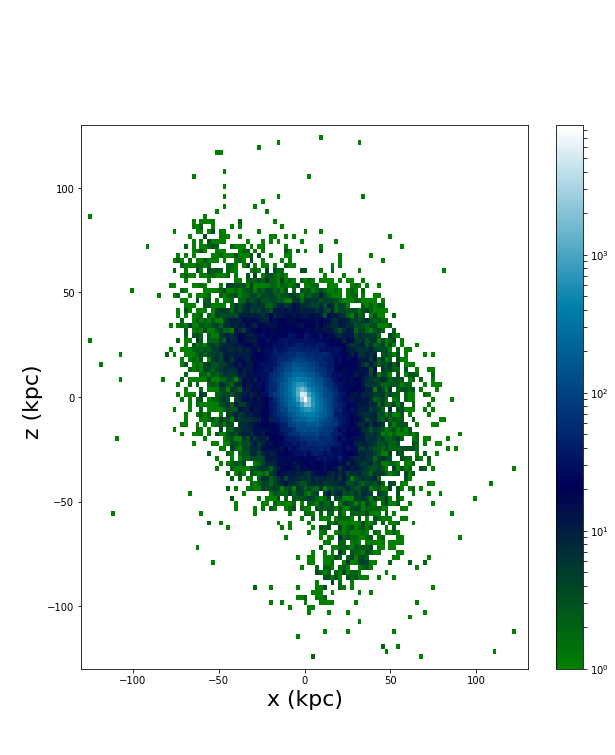

In [9]:
# Rotated Remnant (x-z plane)

# Remnant Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for Remnant , 2D histogram
# ADD HERE
plt.hist2d(rnew[:,0], rnew[:,2], bins = 150, norm = LogNorm(), cmap = 'ocean')

plt.colorbar()

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-130,130)
plt.xlim(-130,130)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



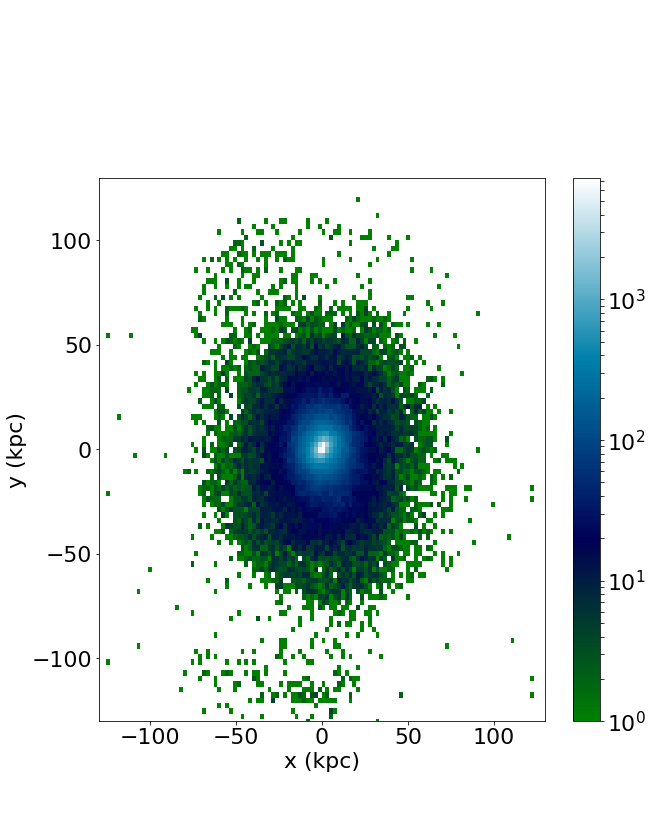

In [10]:
# Rotated Remnant - (x-y plane)

# Remnant Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for remnant 
# ADD HERE
plt.hist2d(rnew[:,0], rnew[:,1], bins = 150, norm = LogNorm(), cmap = 'ocean')

plt.colorbar()

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
# ADD HERE
#density_contour(rnew[:,0], rnew[:,1], 80, 80, ax=ax, colors=['magenta', 'red', 'pink', 'orange', 'yellow'])

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-130,130)
plt.xlim(-130,130)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size




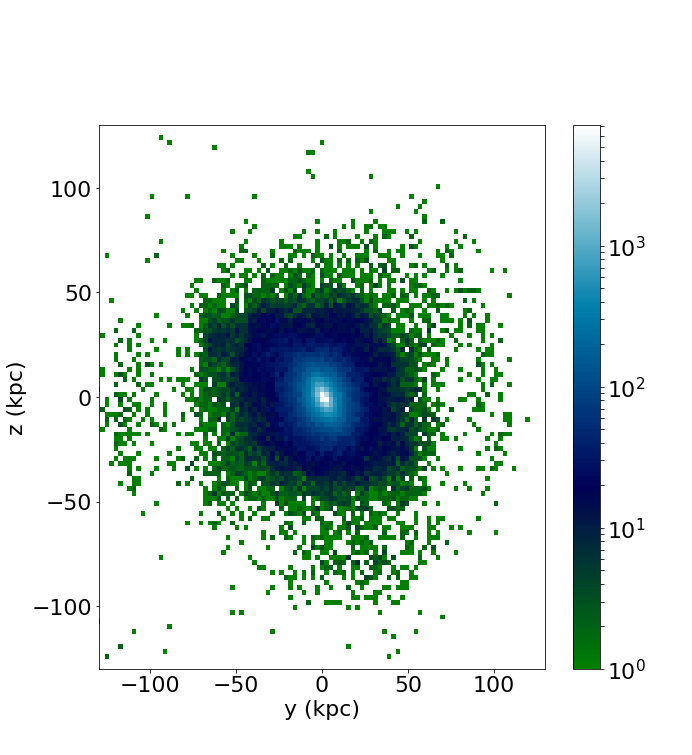

In [11]:
# Rotated Remnant - (y-z plane)

# Remnant Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for remnant 
# ADD HERE
plt.hist2d(rnew[:,1], rnew[:,2], bins = 150, norm = LogNorm(), cmap = 'ocean')

plt.colorbar()

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
# ADD HERE
#density_contour(rnew[:,0], rnew[:,1], 80, 80, ax=ax, colors=['magenta', 'red', 'pink', 'orange', 'yellow'])

# Add axis labels
plt.xlabel('y (kpc)', fontsize=22)
plt.ylabel('z (kpc)', fontsize=22)

#set axis limits
plt.ylim(-130,130)
plt.xlim(-130,130)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size




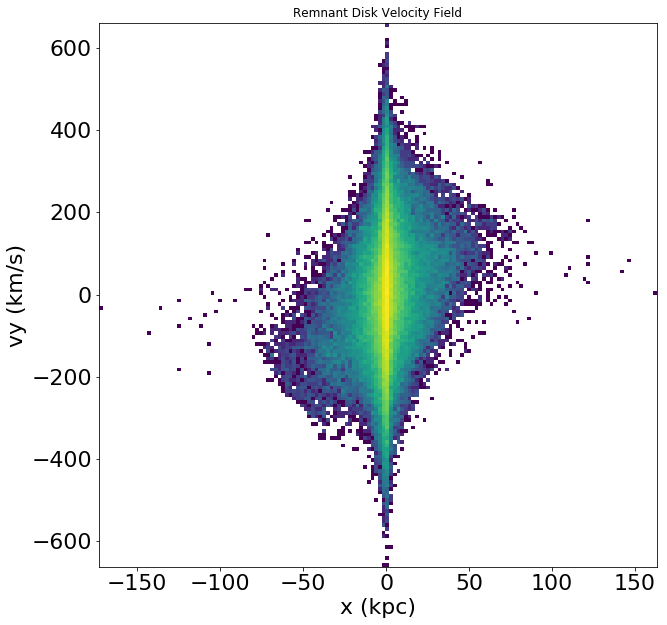

In [12]:
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
# Remnant Disk Velocity Field

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
# ADD HERE
plt.hist2d(rnew[:,0], vnew[:,1], bins = 150, norm=LogNorm())

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('vy (km/s)', fontsize=22)
plt.title("Remnant Disk Velocity Field")

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#plt.savefig("/Users/Maddog/Downloads/M31DiskVelocity.png")

#seems to be most "peak like" behavior here in terms of rotation, graph seems to have the most peak at some positive 
#and negative value


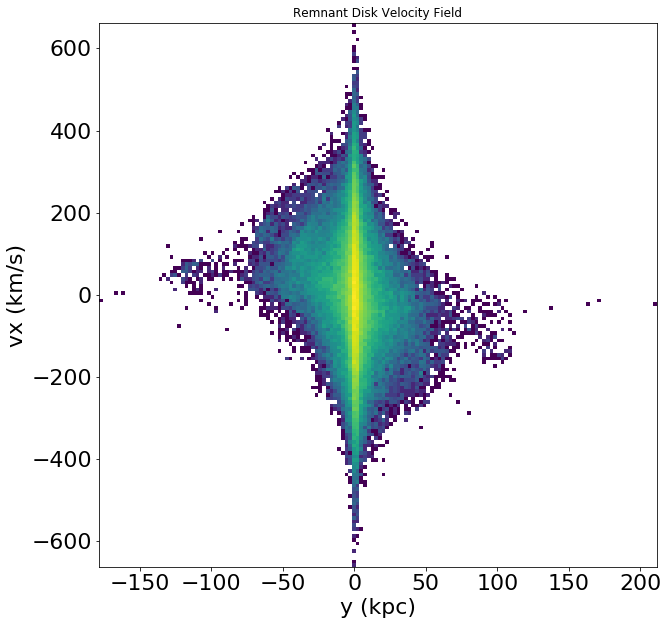

In [13]:
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
# Remnant Disk Velocity Field.

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
# ADD HERE
plt.hist2d(rnew[:,1], vnew[:,0], bins = 150, norm=LogNorm())

# Add axis labels
plt.xlabel('y (kpc)', fontsize=22)
plt.ylabel('vx (km/s)', fontsize=22)
plt.title("Remnant Disk Velocity Field")

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#plt.savefig("/Users/Maddog/Downloads/M31DiskVelocity.png")



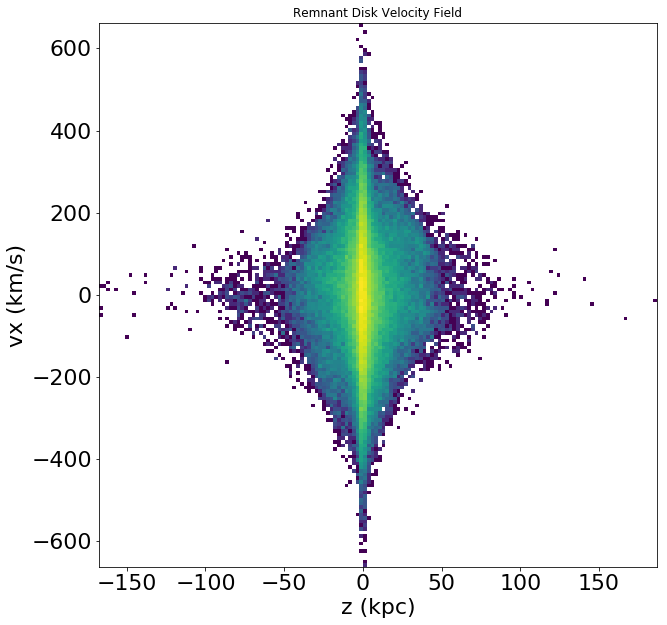

In [14]:
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
# MW Disk Velocity Field edge on.

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
# ADD HERE
plt.hist2d(rnew[:,2], vnew[:,0], bins = 150, norm=LogNorm())

# Add axis labels
plt.xlabel('z (kpc)', fontsize=22)
plt.ylabel('vx (km/s)', fontsize=22)
plt.title("Remnant Disk Velocity Field")

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#plt.savefig("/Users/Maddog/Downloads/M31DiskVelocity.png")


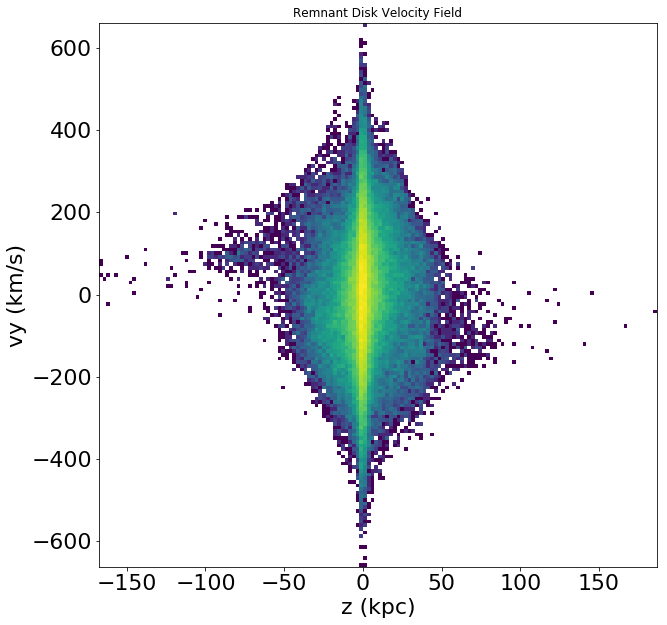

In [15]:
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
# Remnant Disk Velocity Field

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
# ADD HERE
plt.hist2d(rnew[:,2], vnew[:,1], bins = 150, norm=LogNorm())

# Add axis labels
plt.xlabel('z (kpc)', fontsize=22)
plt.ylabel('vy (km/s)', fontsize=22)
plt.title("Remnant Disk Velocity Field")

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#plt.savefig("/Users/Maddog/Downloads/M31DiskVelocity.png")




In [16]:
#create a function to calculate the mean velocities, and spread of velocities for stars on a given axis
#create a "slit" of points along an axis (e.g. along x-axis, go along chunks of x-axis with dx, where dy and dz are small)
#select points in the slit using index, calculate mean velocity and dispersion within slit along axis

def VelocityMeansandDispersions(axis, rdata, vdata, dx, dy, dz):
    #Inputs: 
        #axis = axis along which mean velocity and dispersion will be calculated
        #rdata = 3D array of positions
        #v = 3D array of velocities
        #dx increment in x
        #dy = increment in y
        #dz = increment in z
    #returns
        #array of mean velocities along axis
        #array of std of velocities along axis
        
    #going to need to take "steps along the strip", so if axis == x, dx = 10, dy = 1, dz = 1
    #for all particles with x coords within dx, dy, dz, find mean velocity and dispersion, store values in 
    #arrays
    if axis == "x":
        #set minimum and maximum values along axis
        xmin = -70.0
        xmax = 70.0
        
        #set bin minimum and maximum for "chunk" of stars to be evaluated
        xbinmin = xmin
        xbinmax = xbinmin + dx
        
        #to set length of means and dispersion arrays, divide the difference between min and max value / dwhatever
        arraylength = (xmax - xmin)/dx
        #print(arraylength)
        
        #initialize means and dispersions array
        vmeans = np.zeros(int(arraylength))
        vdispersions = np.zeros(int(arraylength))
        
        #initialize dummy index
        i = 0
        
        #loop over values while the maximum bin value is less than the maximum x value
        while xbinmax < xmax:
            #print(xbinmin)
            #make index to find points within bin minimum and maximum along axis, and have small deviations from axis
            index2 = np.where((rdata[:,0] <= xbinmax) & (rdata[:,0] > xbinmin) & (abs(rdata[:,1]) <= dy) & (abs(rdata[:,2]) <= dz))
            
            #select the velocity values (going out of the page) of the stars that satisfy the index
            vy = vdata[:,1][index2]
            print(len(vy))
            
            #calculate the mean and dispersion of the chunk of stars
            vmeans[i] = np.mean(vy)
            vdispersions[i] = np.std(vy)
            
            #increment dummy index, bin minimum, bin maximum
            i = i + 1
            xbinmin = xbinmin + dx
            xbinmax = xbinmax + dx
            
        #print(i)
            
    if axis == "y":
        #set minimum and maximum values along axis
        ymin = -70.0 
        ymax = 70.0
        
        #set bin minimum and maximum for "chunk" of stars to be evaluated
        ybinmin = ymin
        ybinmax = ybinmin + dy
        
        #to set length of means and dispersion arrays, divide the difference between min and max value / dwhatever
        arraylength = (ymax - ymin)/dy
        
        #initialize means and dispersions array
        vmeans = np.zeros(int(arraylength))
        vdispersions = np.zeros(int(arraylength))
        
        #initialize dummy index
        i = 0
        
        #loop over values while the maximum bin value is less than the maximum x value
        while ybinmax < ymax:
            #make index to find points within bin minimum and maximum along axis, and have small deviations from axis
            index2 = np.where((rdata[:,1] <= ybinmax) & (rdata[:,1] > ybinmin) & (abs(rdata[:,0]) <= dx) & (abs(rdata[:,2]) <= dz))
            
            #select the velocity values (going out of the page) of the stars that satisfy the index
            vx = vdata[:,0][index2]
            
            #calculate the mean and dispersion of the chunk of stars
            vmeans[i] = np.mean(vx)
            vdispersions[i] = np.std(vx)
            
            #increment dummy index, bin minimum, bin maximum
            i = i + 1
            ybinmin = ybinmin + dy
            ybinmax = ybinmax + dy
            
    if axis == "z":
        #set minimum and maximum values along axis
        zmin = -70.0 
        zmax = 70.0
        
        #set bin minimum and maximum for "chunk" of stars to be evaluated
        zbinmin = zmin
        zbinmax = zbinmin + dz
        
        #to set length of means and dispersion arrays, divide the difference between min and max value / dwhatever
        arraylength = (zmax - zmin)/dz
        
        #initialize means and dispersions array
        vmeans = np.zeros(int(arraylength))
        vdispersions = np.zeros(int(arraylength))
        
        #initialize dummy index
        i = 0
        
        #loop over values while the maximum bin value is less than the maximum x value
        #calculate mean and dispersion around mean in each loop
        while zbinmax < zmax:
            #make index to find points within bin minimum and maximum along axis, and have small deviations from axis
            index2 = np.where((rdata[:,2] <= zbinmax) & (rdata[:,2] > zbinmin) & (abs(rdata[:,0]) <= dx) & (abs(rdata[:,1]) <= dy))
            
            #select the velocity values (going out of the page) of the stars that satisfy the index 
            #could be x or y axis for looking along z? Does it matter which one? (Chose x for now)
            vx = vdata[:,0][index2]
            
            #calculate the mean and dispersion of the chunk of stars
            vmeans[i] = np.mean(vx)
            vdispersions[i] = np.std(vx)
            
            #increment dummy index, bin minimum, bin maximum
            i = i + 1
            zbinmin = zbinmin + dz
            zbinmax = zbinmax + dz      
    
    return vmeans, vdispersions 

In [23]:
#test 1, along x axis, want dx to be larger and dy and dz to be small (but how small??) maybe start with dx = 5kpc, dy = 0.5kpc, dz = 0.5kpc
means, dispersions = VelocityMeansandDispersions("x", rnew, vnew, 5, 5, 5)
means2, dispersions2 = VelocityMeansandDispersions("y", rnew, vnew, 0.5, 5, 0.5)
means3, dispersions3 = VelocityMeansandDispersions("z", rnew, vnew, 0.5, 0.5, 5)
#Hmmmm seem to be getting a lot of nans, not sure why
#len(means)
#print(len(dispersions))
#plt.scatter(means, dispersions)

#Also not sure why some bins have a ton more stars, I get that it gets denser as you get closer to the center of the remnant
#but also that's a lot

1
2
0
3
6
2
7
17
24
50
173
583
1756
16984
15912
1722
518
177
78
27
21
15
3
8
1
1
3


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


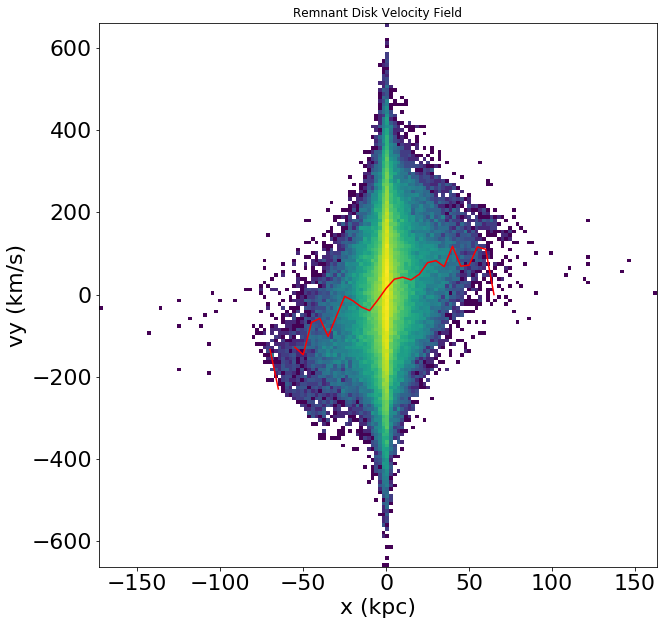

In [24]:
#overplot the means as a function of axis on the phase diagram from above

xvalues = np.arange(-70, 70, 5)
# Make a phase diagram for each x, y, z axis, where v component is component that points out of board
# Remnant Disk Velocity Field

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot 2D Histogram one component of  Pos vs Vel 
# ADD HERE
plt.hist2d(rnew[:,0], vnew[:,1], bins = 150, norm=LogNorm())

plt.plot(xvalues, means, color = "red")

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('vy (km/s)', fontsize=22)
plt.title("Remnant Disk Velocity Field")

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#plt.savefig("/Users/Maddog/Downloads/M31DiskVelocity.png")

#seems to be most "peak like" behavior here in terms of rotation, graph seems to have the most peak at some positive 
#and negative value



In [19]:
#to get peak mean velocity, take peak velocity from means array (mean vy vs x)
#but first only take the finite values
index3 = np.isfinite(means)
means = means[index3]

peakvel = max(means)

In [ ]:
#Next steps: get peak mean velocity then take the ratio of that value 
#to the total dispersion (averaged in spherical shells) to compute V/sigma
#i.e. to determine whether remnant is a fast or slow rotator